# Question 6.2 : 

In [1]:
def phi(A,x,b):
  return  - np.sum(np.log(b- A@x))

def f(Q,p,x):
  return (x.T @ Q @ x + p.T@x)

def g(t,Q,A,p,x,b):

  return t*f(Q,p,x) + phi(A,x,b)

# Note : 
We implement the cholesky inversion for it being numericaly more stable.

When back tracking we have to make sure that we stay inside the domain of our function, otherwise we reduce our step size


In [2]:

def gradient(x, Q, p, A, t,b):
    h = 1. / (b - A @ x)

    return t * (2 * Q @ x + p) + A.T @ h

def hessian(x, Q, p, A, t,b):
    h = 1. / (b- A @ x)
    h = h.reshape(-1)
    return 2 * t * Q + A.T @ np.diag(h)**2 @ A


def cholesky_inv(X):
  # Cholesky decomposition inversion:
  c = np.linalg.inv(np.linalg.cholesky(X))
  inverse = np.dot(c.T,c)
  return inverse

In [3]:
def backtrack(t,Q,A,p,x,grad,newton_step,b):
  
  step =1 
  alpha = 0.4
  beta = 0.8

  while ((b - A@ (x + step*newton_step)) <0).any() or g(t,Q,A,p,x + step * newton_step ,b) > (g(t,Q,A,p,x,b) + alpha * step * grad.T @ newton_step):

    step *= beta

  assert ((b - A@ (x + step*newton_step)) >0).all()

  return step



def centering_step(t,Q,A,p,x,eps,b):

  pt_history= []

  while True:
      
    grad=gradient(x, Q, p, A, t,b)
    hess = hessian(x, Q, p, A, t,b)

    inv_hess = cholesky_inv(hess)

    newton_dec = grad.T @ inv_hess @ grad

    if newton_dec/2 < eps :
      break
    
    newton_step = - inv_hess @ grad
      
    step_size = backtrack(t,Q,A,p,x,grad,newton_step,b)

    pt_history.append(x)

    x = x + step_size * newton_step

  
  return pt_history
  

In [4]:
def barrier_method(Q,p,A,x,eps,u,b):
  
  t=1

  d = A.shape[0] ## number of constraints

  whole_path = []
  
  while ( (d/t) > eps):

    path = centering_step(t,Q,A,p,x,eps,b)

    whole_path += path
    x = path[-1]
    t = u*t

  return whole_path,x


In [9]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt




n= 200 ## number of points
std = 4 ## std of each cluster
centers = [(-1, -1), (1, 1)] ## cluster centers 

x,y = datasets.make_blobs(n_samples=n, n_features=2, centers=centers, cluster_std=std, shuffle=True, random_state=None)
y[y==0]=-1

def generate_experience(C,n=n,x=x,y=y):

    

    C = C

    A = np.vstack((np.eye(n),-np.eye(n)))

    Q = 0.5 * np.diag(y) @ x @ x.T @ np.diag(y)

    p = - np.ones((n,1))

    x0 =0.5* C * np.ones((n,1))

    ### BARRIER CONDITION ###

    b = np.vstack((C * np.ones((n,1)),np.zeros((n,1))))

    return Q,p,A,x0,b


# Q2 

Plot convergence of the objective function in Newton iterations for the barrier problem
(i.e. inner iterations), with respect to the best value found, in semilog scale.

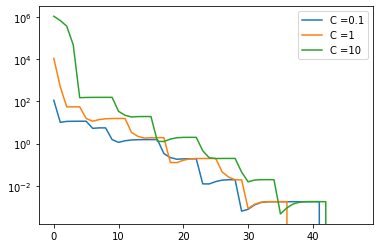

In [10]:
eps = 1e-4
u = 10
Cs = [0.1,1,10]

Ws = []

for C in Cs:
    Q,p,A,x0,b = generate_experience(C=C)
    path,v=barrier_method(Q,p,A,x0,eps,u,b)
    Ws.append(v.T @ np.diag(y)@ x)
    ys = [np.squeeze(f(Q,p,x)) for x in path]
    plt.semilogy(ys-ys[-1],label='C ='+str(C))
  

plt.legend()
plt.show()

#Q3 :

Plot the decision boundaries for the different values of W

The decision boudndary slope is  $S = \frac{-w1}{w2}$

We tried for various blob centroids and deviations but for the slope is almost the same for all values of C

Ponte 0 = [-0.78849506]
Ponte 1 = [-0.78846933]
Ponte 2 = [-0.7884563]


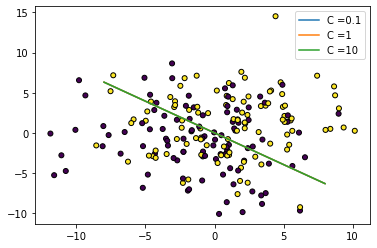

In [12]:
def plot_decision_boundary(std,x,y,Ws,Cs):


  plt.scatter(x[:, 0], x[:, 1], marker='o', c=y,
              s=25, edgecolor='k')
  X = np.linspace(-2*std,2*std,100)

  for i,w in enumerate(Ws) :
    w = w.T
    w1 = w[0]
    w2 = w[1]
    c = - w1/w2
    print("Ponte",i,'=',c)
    Y = c * X
    plt.plot(X,Y,label='C ='+str(Cs[i]))
  
  
  plt.legend()
  plt.show()


plot_decision_boundary(std,x,y,Ws,Cs)